In [19]:
import numpy as np
import matplotlib.pyplot as plt


In [20]:
# Rocket class that holds all these variables
class Rocket:
    def __init__(self):
        # Rocket properties
        self.dry_mass = 80.28  # kg
        self.prop_mass = 30.39  # kg
        self.burn_time = 5.647  # s
        self.mass = self.dry_mass + self.prop_mass  # kg
        self.mdot = self.prop_mass / self.burn_time  # kg/s
        self.cd = 0  # unitless (initialized later)
        self.diameter = 0.2032  # m
        self.reference_area = 3.1415926535 * (self.diameter / 2) ** 2  # m^2

        # Engine properties
        self.chamber_k = 1.1926  # unitless
        self.chamber_M = 0.023889  # kg/mol
        self.chamber_R = 8.31446261815324 / self.chamber_M  # J/(kg*K)
        self.chamber_temp = 3016.32  # K
        self.chamber_pressure = 3447378.64  # Pa
        self.throat_area = 0.00246362965667312  # m^2
        self.nc_star = 0.9  # unitless
        self.ncf = 0.98  # unitless
        self.exit_area = 0  # m^2 (initialized later)
        self.exit_pressure = 0  # Pa (initialized later)
        self.exit_velocity = 0  # m/s (initialized later)
        self.thrust = 0  # N (initialized later)
        self.drag = 0 # N (initialized later)

        # Kinematic properties
        self.height = 0  # m
        self.velocity = 0  # m/s
        self.mach_no = 0  # unitless
        self.acceleration = 0  # m/s^2
        self.t = 0  # s

        # Environment properties
        self.sea_level = 620  # m (elevation of FAR launch site)
        self.ambient_pressure = 0  # Pa (initialized later)
        self.ambient_temp = 0  # K (initialized later)
        self.ambient_speed_of_sound = 0  # m/s (initialized later)
        self.ambient_density = 0  # kg/m^3 (initialized later)
        self.g = 9.80665  # m/s^2
        self.dt = 0.01  # s

In [21]:
def calc_ambient_pressure(rocket):
    # Calculate the ambient pressure (Pa) at a given height (https://en.wikipedia.org/wiki/Atmospheric_pressure)

    p0 = 101325  # Sea level standard atmospheric pressure, Pa
    T0 = 288.15  # Sea level standard temperature, K
    L = 0.00876  # Temperature lapse rate, K/m
    g = 9.80665  # Gravitational acceleration, m/s^2
    M = 0.02896968  # Molar mass of dry air, kg/mol
    R0 = 8.31446261815324  # Universal gas constant, J/(mol*K)

    rocket.ambient_pressure = p0 * (
        1 - (L * (rocket.height + rocket.sea_level)) / T0
    ) ** ((g * M) / (R0 * L))


def calc_exit_velocity(rocket):
    # Calculate the exit velocity (m/s) given the exit pressure and engine properties

    k = rocket.chamber_k  # unitless
    R = rocket.chamber_R  # J/(kg*K)
    T = rocket.chamber_temp  # K
    p1 = rocket.chamber_pressure  # Pa
    nc_star = rocket.nc_star  # unitless
    ncf = rocket.ncf  # unitless

    # Derived correction factor based on nc_star and ncf vairables.
    p2 = rocket.exit_pressure
    p3 = rocket.ambient_pressure
    A2 = rocket.exit_area
    mdot = rocket.mdot
    alpha = (p2 - p3) * A2 * (1 / mdot)  # Arbitary name for this quantity.

    rocket.exit_velocity = (
        (
            (
                (
                    (2 * k / (k - 1))
                    * R
                    * T
                    * (1 - (rocket.exit_pressure / p1) ** ((k - 1) / k))
                )
                ** 0.5
            )
            * nc_star
            * ncf
        )
        + (alpha * nc_star * ncf)
        - alpha
    )


def calc_exit_area(rocket):
    # Calculate the exit area (m^2) given the exit pressure and engine properties

    k = rocket.chamber_k  # unitless
    p1 = rocket.chamber_pressure  # Pa
    At = rocket.throat_area  # m^2

    rocket.exit_area = (
        ((k + 1) / 2) ** (1 / (k - 1))
        * (rocket.exit_pressure / p1) ** (1 / k)
        * (((k + 1) / (k - 1)) * (1 - (rocket.exit_pressure / p1) ** ((k - 1) / k)))
        ** 0.5
        * (1 / At)
    ) ** -1


def calc_thrust(rocket):
    # Calculate the thrust (N) given the exit pressure and engine properties

    if rocket.t > rocket.burn_time:
        rocket.thrust = 0
        return

    mdot = rocket.mdot  # kg/s
    v2 = rocket.exit_velocity  # m/s
    p2 = rocket.exit_pressure  # Pa
    p3 = rocket.ambient_pressure  # Pa
    Ae = rocket.exit_area  # m^2

    rocket.thrust = mdot * v2 + Ae * (p2 - p3)


def calc_ambient_temp(rocket):
    # Calculate the ambient temperature (K) given the height of rocket

    T0 = 288.15  # Sea level standard temperature, K
    L = 0.00876  # Temperature lapse rate, K/m
    rocket.ambient_temp = T0 - L * (rocket.height + rocket.sea_level)


def calc_ambient_speed_of_sound(rocket):
    # Calculate the ambient speed of sound (m/s) given the ambient temperature

    k = 1.4
    R = 287.05
    rocket.ambient_speed_of_sound = (k * R * rocket.ambient_temp) ** 0.5


def calc_mach_no(rocket):
    # Calculate the Mach number (unitless) given the speed of rocket

    rocket.mach_no = rocket.velocity / rocket.ambient_speed_of_sound


def calc_ambient_density(rocket):
    # Calculate the ambient density (kg/m^3) given the ambient pressure and temperature

    R = 287.05
    rocket.ambient_density = rocket.ambient_pressure / (rocket.ambient_temp * R)


def calc_cd(rocket):
    # Calculate the drag coefficient (unitless) given the speed of rocket

    M = rocket.mach_no  # unitless

    if M <= 0.6:
        rocket.cd = 0.208333 * M**2 - 0.25 * M + 0.46
    elif 0.6 < M <= 0.8:
        rocket.cd = 1.25 * M**3 - 2.125 * M**2 + 1.2 * M + 0.16
    elif 0.8 < M <= 0.95:
        rocket.cd = 10.37037 * M**3 - 22.88889 * M**2 + 16.91111 * M - 3.78963
    elif 0.95 < M <= 1.05:
        rocket.cd = -30 * M**3 + 88.5 * M**2 - 85.425 * M + 27.51375
    elif 1.05 < M <= 1.15:
        rocket.cd = -20 * M**3 + 60 * M**2 - 58.65 * M + 19.245
    elif 1.15 < M <= 1.3:
        rocket.cd = 11.85185 * M**3 - 44.88889 * M**2 + 56.22222 * M - 22.58519
    elif 1.3 < M <= 2:
        rocket.cd = -0.04373178 * M**3 + 0.3236152 * M**2 - 1.019679 * M + 1.554572
    elif 2 < M <= 3.25:
        rocket.cd = 0.01024 * M**3 - 0.00864 * M**2 - 0.33832 * M + 1.08928
    elif 3.25 < M <= 4.5:
        rocket.cd = -0.01048 * M**3 + 0.19168 * M**2 - 0.86976 * M + 1.53544
    else:  # M > 4.5
        rocket.cd = 0.22


def calc_drag(rocket):
    # Calculate the drag force (N) given the drag coefficient and speed of rocket

    drag = (
        0.5
        * rocket.ambient_density
        * rocket.velocity**2
        * rocket.cd
        * rocket.reference_area
    )

    if rocket.velocity < 0:
        drag = -drag

    rocket.drag = drag

In [22]:
def initialize_rocket(rocket, p2):
    # Initialize the rocket's exit area, exit pressure, exit velocity, and thrust

    rocket.exit_pressure = p2

    calc_ambient_pressure(rocket)
    calc_exit_area(rocket)
    calc_exit_velocity(rocket)
    calc_thrust(rocket)
    calc_ambient_temp(rocket)
    calc_ambient_density(rocket)
    calc_ambient_speed_of_sound(rocket)
    calc_mach_no(rocket)
    calc_cd(rocket)
    calc_drag(rocket)

In [23]:
def update_rocket(rocket):
    if rocket.prop_mass > 0:
        # Sum of forces
        net_force = rocket.thrust - (rocket.mass * rocket.g) - rocket.drag

        # Propellant mass change
        rocket.prop_mass = rocket.prop_mass - rocket.mdot * rocket.dt
        rocket.mass = rocket.dry_mass + rocket.prop_mass

    else:
        net_force = -(rocket.mass * rocket.g) - rocket.drag

    # Kinematic variable changes
    rocket.acceleration = net_force / rocket.mass
    rocket.velocity = rocket.velocity + rocket.acceleration * rocket.dt
    rocket.height = rocket.height + rocket.velocity * rocket.dt
    rocket.t = rocket.t + rocket.dt

    # Update all the other variables
    calc_ambient_pressure(rocket)
    calc_exit_area(rocket)
    calc_exit_velocity(rocket)
    calc_thrust(rocket)
    calc_ambient_temp(rocket)
    calc_ambient_density(rocket)
    calc_ambient_speed_of_sound(rocket)
    calc_mach_no(rocket)
    calc_cd(rocket)
    calc_drag(rocket)

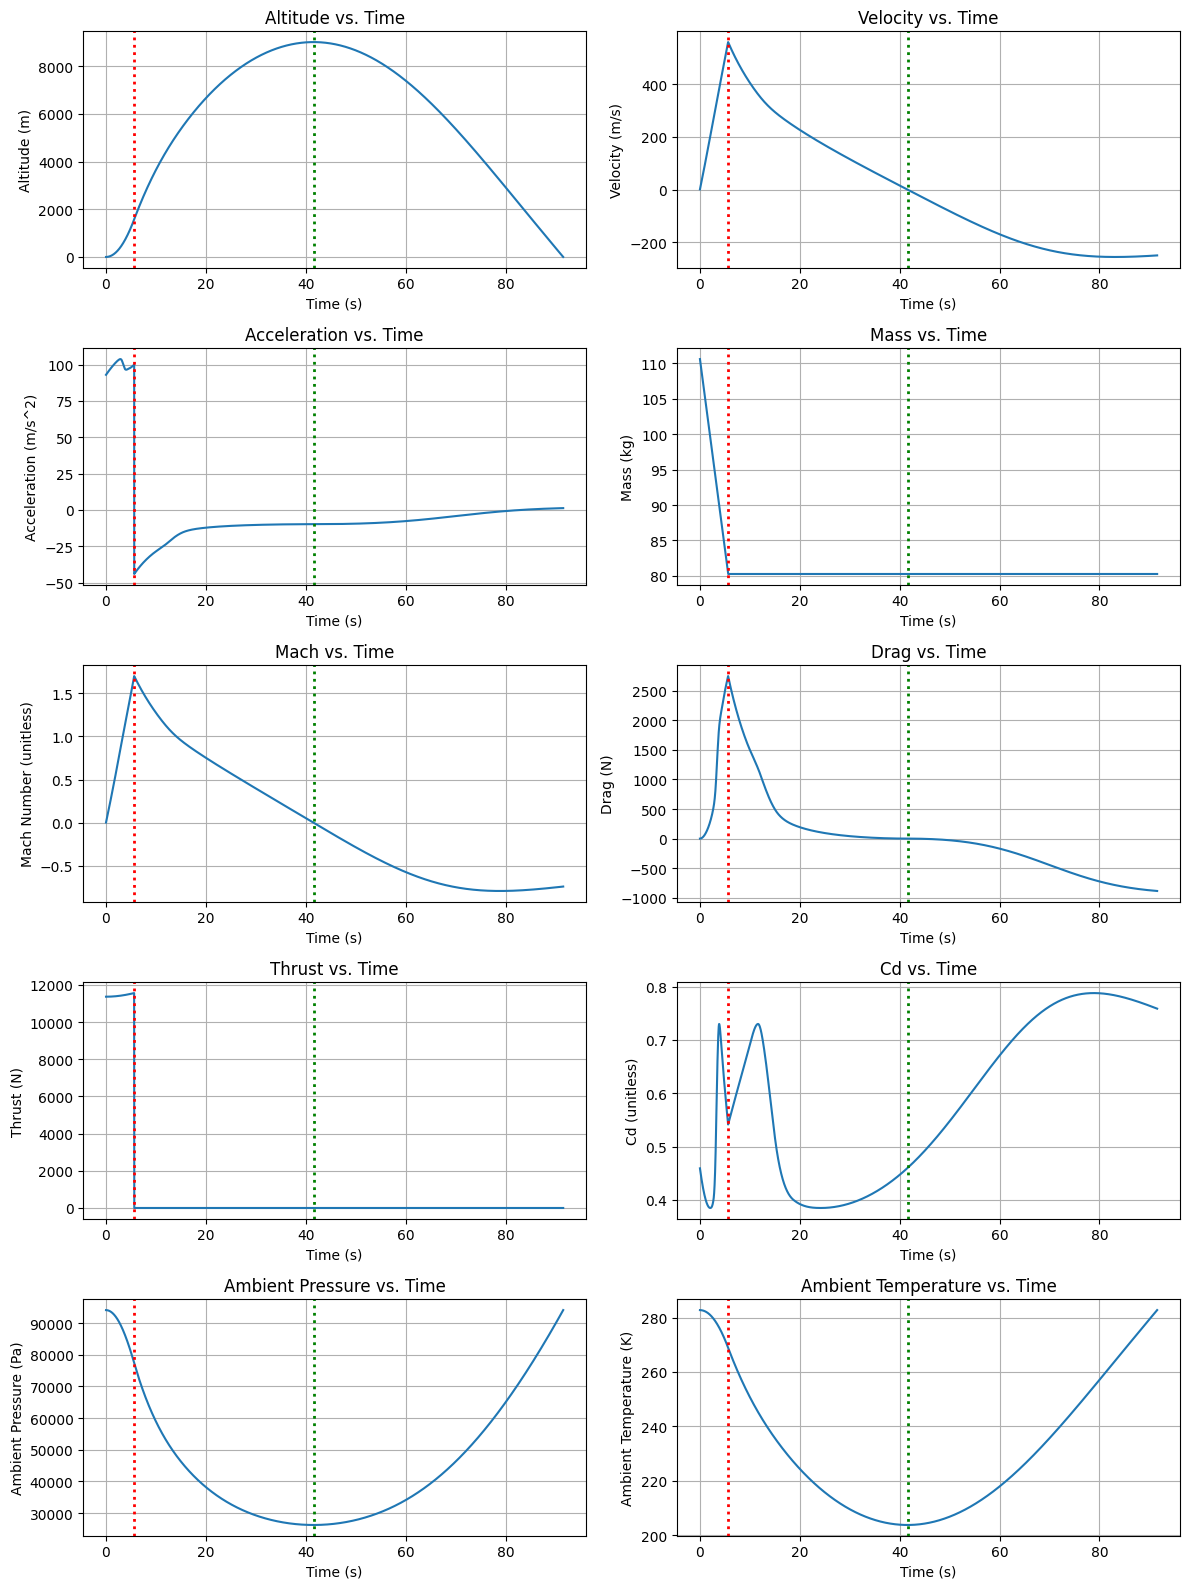

In [24]:
rocket = Rocket()
initialize_rocket(rocket, 101352.9)

# Initialize lists to store altitude, velocity, acceleration, mass, Mach number, drag, thrust, and time values
altitude_values = []
velocity_values = []
acceleration_values = []
mass_values = []
mach_values = []
cd_values = []
thrust_values = []
drag_values = []
time_values = []
ambient_pressure_values = []
ambient_temperature_values = []

# Loop until rocket hits the ground or reaches 1000 increments
loop_increment = 0
while rocket.height >= 0:  # and loop_increment < 1000:
    loop_increment += 1
    # print(f"Loop increment: {loop_increment}")

    # Update rocket variables
    update_rocket(rocket)

    # Store altitude, velocity, acceleration, mass, Mach number, drag, thrust, and time values
    altitude_values.append(rocket.height)
    velocity_values.append(rocket.velocity)
    acceleration_values.append(rocket.acceleration)
    mass_values.append(rocket.mass)
    mach_values.append(rocket.mach_no)
    cd_values.append(rocket.cd)
    thrust_values.append(rocket.thrust)
    drag_values.append(rocket.drag)
    time_values.append(rocket.t)
    ambient_pressure_values.append(rocket.ambient_pressure)
    ambient_temperature_values.append(rocket.ambient_temp)

import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(5, 2, figsize=(12, 16))

# Plot 1: Altitude
axs[0, 0].plot(time_values, altitude_values)
axs[0, 0].set_xlabel("Time (s)")
axs[0, 0].set_ylabel("Altitude (m)")
axs[0, 0].set_title("Altitude vs. Time")
axs[0, 0].axvline(x=rocket.burn_time, color="red", linestyle="dotted", linewidth=2)
axs[0, 0].grid(True)
axs[0, 0].axvline(
    x=time_values[altitude_values.index(max(altitude_values))],
    color="green",
    linestyle="dotted",
    linewidth=2,
)  # Add vertical line at apogee

# Plot 2: Velocity
axs[0, 1].plot(time_values, velocity_values)
axs[0, 1].set_xlabel("Time (s)")
axs[0, 1].set_ylabel("Velocity (m/s)")
axs[0, 1].set_title("Velocity vs. Time")
axs[0, 1].axvline(x=rocket.burn_time, color="red", linestyle="dotted", linewidth=2)
axs[0, 1].grid(True)
axs[0, 1].axvline(
    x=time_values[altitude_values.index(max(altitude_values))],
    color="green",
    linestyle="dotted",
    linewidth=2,
)  # Add vertical line at apogee

# Plot 3: Acceleration
axs[1, 0].plot(time_values, acceleration_values)
axs[1, 0].set_xlabel("Time (s)")
axs[1, 0].set_ylabel("Acceleration (m/s^2)")
axs[1, 0].set_title("Acceleration vs. Time")
axs[1, 0].axvline(x=rocket.burn_time, color="red", linestyle="dotted", linewidth=2)
axs[1, 0].grid(True)
axs[1, 0].axvline(
    x=time_values[altitude_values.index(max(altitude_values))],
    color="green",
    linestyle="dotted",
    linewidth=2,
)  # Add vertical line at apogee

# Plot 4: Mass
axs[1, 1].plot(time_values, mass_values)
axs[1, 1].set_xlabel("Time (s)")
axs[1, 1].set_ylabel("Mass (kg)")
axs[1, 1].set_title("Mass vs. Time")
axs[1, 1].axvline(x=rocket.burn_time, color="red", linestyle="dotted", linewidth=2)
axs[1, 1].grid(True)
axs[1, 1].axvline(
    x=time_values[altitude_values.index(max(altitude_values))],
    color="green",
    linestyle="dotted",
    linewidth=2,
)  # Add vertical line at apogee

# Plot 5: Mach Number
axs[2, 0].plot(time_values, mach_values)
axs[2, 0].set_xlabel("Time (s)")
axs[2, 0].set_ylabel("Mach Number (unitless)")
axs[2, 0].set_title("Mach vs. Time")
axs[2, 0].axvline(x=rocket.burn_time, color="red", linestyle="dotted", linewidth=2)
axs[2, 0].grid(True)
axs[2, 0].axvline(
    x=time_values[altitude_values.index(max(altitude_values))],
    color="green",
    linestyle="dotted",
    linewidth=2,
)  # Add vertical line at apogee

# Plot 6: Drag
axs[2, 1].plot(time_values, drag_values)
axs[2, 1].set_xlabel("Time (s)")
axs[2, 1].set_ylabel("Drag (N)")
axs[2, 1].set_title("Drag vs. Time")
axs[2, 1].axvline(x=rocket.burn_time, color="red", linestyle="dotted", linewidth=2)
axs[2, 1].grid(True)
axs[2, 1].axvline(
    x=time_values[altitude_values.index(max(altitude_values))],
    color="green",
    linestyle="dotted",
    linewidth=2,
)  # Add vertical line at apogee

# Plot 7: Thrust
axs[3, 0].plot(time_values, thrust_values)
axs[3, 0].set_xlabel("Time (s)")
axs[3, 0].set_ylabel("Thrust (N)")
axs[3, 0].set_title("Thrust vs. Time")
axs[3, 0].axvline(x=rocket.burn_time, color="red", linestyle="dotted", linewidth=2)
axs[3, 0].grid(True)
axs[3, 0].axvline(
    x=time_values[altitude_values.index(max(altitude_values))],
    color="green",
    linestyle="dotted",
    linewidth=2,
)  # Add vertical line at apogee

# Plot 8: Cd (Drag Coefficient)
axs[3, 1].plot(time_values, cd_values)
axs[3, 1].set_xlabel("Time (s)")
axs[3, 1].set_ylabel("Cd (unitless)")
axs[3, 1].set_title("Cd vs. Time")
axs[3, 1].axvline(x=rocket.burn_time, color="red", linestyle="dotted", linewidth=2)
axs[3, 1].grid(True)
axs[3, 1].axvline(
    x=time_values[altitude_values.index(max(altitude_values))],
    color="green",
    linestyle="dotted",
    linewidth=2,
)  # Add vertical line at apogee

# Plot 9: Ambient Pressure
axs[4, 0].plot(time_values, ambient_pressure_values )
axs[4, 0].set_xlabel("Time (s)")
axs[4, 0].set_ylabel("Ambient Pressure (Pa)")
axs[4, 0].set_title("Ambient Pressure vs. Time")
axs[4, 0].axvline(x=rocket.burn_time, color="red", linestyle="dotted", linewidth=2)
axs[4, 0].grid(True)
axs[4, 0].axvline(
    x=time_values[altitude_values.index(max(altitude_values))],
    color="green",
    linestyle="dotted",
    linewidth=2,
)  # Add vertical line at apogee

# Plot 10: Ambient Temperature
axs[4, 1].plot(time_values, ambient_temperature_values )
axs[4, 1].set_xlabel("Time (s)")
axs[4, 1].set_ylabel("Ambient Temperature (K)")
axs[4, 1].set_title("Ambient Temperature vs. Time")
axs[4, 1].axvline(x=rocket.burn_time, color="red", linestyle="dotted", linewidth=2)
axs[4, 1].grid(True)
axs[4, 1].axvline(
    x=time_values[altitude_values.index(max(altitude_values))],
    color="green",
    linestyle="dotted",
    linewidth=2,
)  # Add vertical line at apogee


# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()